## Honda

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from matplotlib import cm, colors
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [2]:
sys.path.append('C:\\Users\\Bruger\\AppStat2021\\External_Functions')
import Clotilde_external_functions as cef

In [3]:
r_theta = r'$\theta$'
r_numu = r'$\nu_{\mu}$'

In [4]:
# cos intervals
cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
cos_strings = []

for i in range(len(cos_values)-1):
    string = f'{cos_values[i+1]} - {cos_values[i]}'
    cos_strings.append(string)

In [5]:
# Loading the data
len_file = 2060
len_subfile = 103
footer_skip_lines = len_file - np.arange(len_subfile, len_file+1, len_subfile)
header_skip_lines = np.arange(2, len_file-len_subfile+3, len_subfile)

# Same energy array for all angles
energy_sp = np.genfromtxt('2.6_sp_solmax.d', skip_header = header_skip_lines[0], 
                          skip_footer = footer_skip_lines[0])[:, 0]

# Matrix with all fluxes
numu_sp_matrix = np.zeros((len(footer_skip_lines), len_subfile-2))

for i in range(len(footer_skip_lines)):
    numu_sp = np.genfromtxt('2.6_sp_solmax.d', skip_header = header_skip_lines[i], 
                            skip_footer = footer_skip_lines[i])[:, 1]
    numu_sp_matrix[i,:] = numu_sp

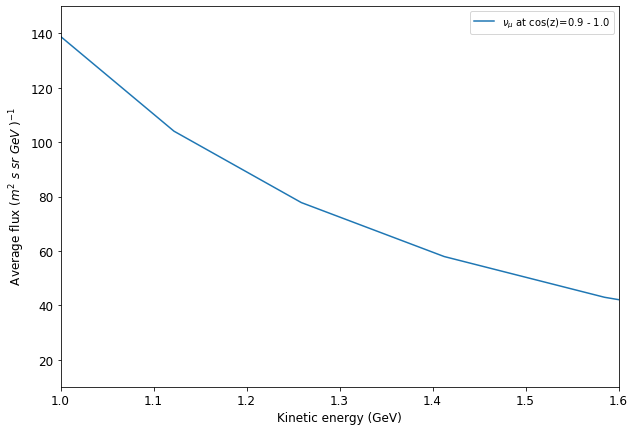

In [6]:
# Plot for cos(z) = 0.9 - 1.0

fig, ax = plt.subplots(figsize=(10,7))
r_phi = r'$\phi_{Az}$'
ax.plot(energy_sp, numu_sp_matrix[0,:], label=f'{r_numu} at cos(z)={cos_strings[0]}')
ax.set_xlabel('Kinetic energy (GeV)', fontsize=12)
ax.set_ylabel(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$', fontsize=12)
ax.set_xlim(1, 1.6)
ax.set_ylim(10, 150)
ax.legend()

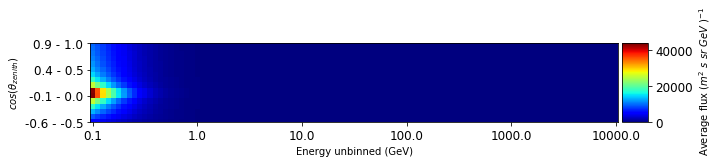

In [7]:
# UNBINNED

#numu_sp_matrix_divided = numu_sp_matrix.copy()

#for i in range(len(numu_sp_matrix_divided[0])):
    #numu_sp_matrix_divided[:, i] /= energy_sp[i] 

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(numu_sp_matrix, cmap='jet')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy unbinned (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks([0, 20, 40, 60, 80, 100])
ax.set_xticklabels([energy_sp[0], energy_sp[20], energy_sp[40], energy_sp[60],
                    energy_sp[80], energy_sp[100]])
ax.set_yticks([0,5,10,15])
ax.set_yticklabels([cos_strings[0], cos_strings[5], cos_strings[10], cos_strings[15]]);
cbar.set_label(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$');

#fig.savefig('Honda_unbinned')

In [83]:
def find_nearest_above(my_array, target):
    
    diff = my_array - target
    mask = np.ma.less_equal(diff, 0)
    
    if np.all(mask):
        return None 
    masked_diff = np.ma.masked_array(diff, mask)
    
    return masked_diff.argmin()

# Limit to range 1-100 GeV
low_x = find_nearest_above(energy_sp, 0.9)
high_x =  find_nearest_above(energy_sp, 100)
energy_cropped = energy_sp[low_x : high_x]
matrix_cropped = numu_sp_matrix[:, low_x : high_x]

# Energy bins
energy_min_cc = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,0]
energy_max_cc = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,1]
energy_bins = np.digitize(energy_cropped, energy_min_cc)
energy_binwidths = energy_max_cc - energy_min_cc

In [65]:
#Binning energies
binned_cropped_matrix = np.zeros((len(numu_sp_matrix[:,0]), len(energy_min_cc)))

# averaging columns in same interval
for i in range(1, len(energy_min_cc)+1):
    columns = np.where(energy_bins == i)[0]
    averaged_column = np.sum(matrix_cropped[ : , columns[0] : columns[-1]], axis = 1)/ len(columns)
    binned_cropped_matrix[ : , i-1 ] = averaged_column

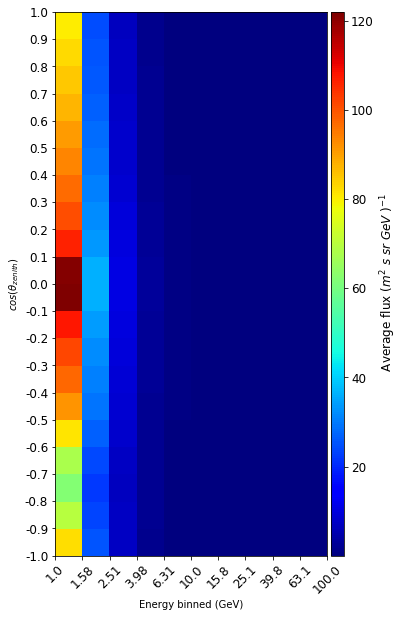

In [78]:
# BINNED PLOT

xticks = np.arange(-0.5, 10.5, 1)
energy_ticklabels = np.append(energy_min_cc, energy_max_cc[-1])
energy_strings = [f'{energy_ticklabels[i]}' for i in range(len(xticks))]

cos_values = np.round(np.arange(1, -1.1, -0.1), 2)
yticks = np.arange(-0.5, 20, 1)
ylabels = [f'{cos_values[i]}' for i in range(len(yticks))]

fig, ax = plt.subplots(figsize=(10,10))

im = ax.imshow(binned_cropped_matrix, cmap='jet') 
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax.set_xlabel('Energy binned (GeV)')
ax.set_ylabel(r'$cos(\theta_{zenith})$')
ax.set_xticks(xticks)
ax.set_xticklabels(energy_strings, rotation=45)
ax.set_yticks(yticks)
ax.set_yticklabels(ylabels);
cbar.set_label(r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$', fontsize=12)
#fig.savefig('Honda_binned_flux');

In [79]:
def flux_plot(matrix, divide = False, title=None, cbar_label = r' Average flux ($m^2$ $s$ $sr$ $GeV$ $)^{-1}$ $GeV^{-1}$', savefig = None):
    
    matrix_plot = matrix.copy()
    
    if divide == True:
        # dividing by energy range
        energy_binwidths = energy_max_cc - energy_min_cc
        for i in range(len(matrix[0])):
            matrix_plot[:, i] /= energy_binwidths[i]
            
    fig, ax = plt.subplots(figsize=(14,10))

    im = ax.imshow(matrix, cmap='jet') 
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cbar = plt.colorbar(im, cax=cax)
    ax.set_xlabel('Energy binned (GeV)', fontsize = 12)
    ax.set_ylabel(r'$cos(\theta_{zenith})$', fontsize = 12)
    ax.set_xticks(xticks)
    ax.set_xticklabels(energy_strings, rotation =45)
    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels)
    ax.set_title(title)
    cbar.set_label(cbar_label, fontsize = 12)
    
    if savefig != None:
        fig.savefig(savefig)
    
    return matrix

In [94]:
# Create a 2D histogram of the total rate of neutrinos in one year from combining
# the flux histogram and the effective area values/histogram. 

# Multiplying effective area with flux

A_eff_cc = np.genfromtxt('numu_cc.csv', skip_header = 1, delimiter =',')[:,2]
A_eff_nc = np.genfromtxt('numu_nc.csv', skip_header = 1, delimiter =',')[:,2]

# Multiplying effective area with flux
rate_cc = binned_cropped_matrix.copy()
rate_nc = binned_cropped_matrix.copy()

for i in range(len(A_eff_cc)):
    rate_cc[:, i] *= A_eff_cc[i]
    rate_nc[:, i] *= A_eff_nc[i]
    
# Multiply by sr
rate_cc *= 4*np.pi/20
rate_nc *= 4*np.pi/20
    
rate_year_cc = rate_cc * 31_556_926    # seconds in a year
rate_year_nc = rate_nc * 31_556_926

# Multiply by energy binwidth
for i in range(len(rate_year_cc[0])):
    rate_year_nc[:, i] *= energy_binwidths[i]
    rate_year_cc[:, i] *= energy_binwidths[i]

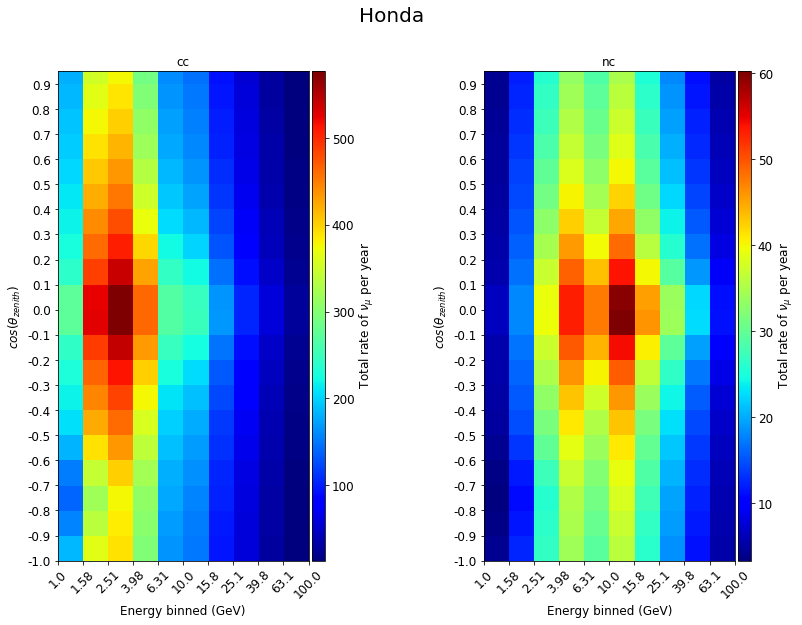

In [99]:
fig, ax = plt.subplots(1, 2, figsize=(14,9))
ax.ravel()

im = ax[0].imshow(rate_year_cc, cmap='jet') 
divider = make_axes_locatable(ax[0])
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)

ax[0].set_xlabel('Energy binned (GeV)', fontsize = 12)
ax[0].set_ylabel(r'$cos(\theta_{zenith})$', fontsize = 12)
ax[0].set_xticks(xticks)
ax[0].set_xticklabels(energy_strings, rotation = 45)
ax[0].set_yticks(yticks)
ax[0].set_yticklabels(ylabels)
ax[0].set_ylim(19.5, 0)
cbar.set_label(r' Total rate of $\nu_{\mu}$ per year', fontsize = 12)
ax[0].set_title('cc')


im = ax[1].imshow(rate_year_nc, cmap='jet') 
divider = make_axes_locatable(ax[1])
cax = divider.append_axes("right", size="5%", pad=0.05)

cbar = plt.colorbar(im, cax=cax)
ax[1].set_xlabel('Energy binned (GeV)', fontsize = 12)
ax[1].set_ylabel(r'$cos(\theta_{zenith})$', fontsize = 12)
ax[1].set_xticks(xticks)
ax[1].set_xticklabels(energy_strings, rotation = 45)
ax[1].set_yticks(yticks)
ax[1].set_yticklabels(ylabels)
ax[1].set_ylim(19.5, 0)
cbar.set_label(r' Total rate of $\nu_{\mu}$ per year', fontsize = 12)
ax[1].set_title('nc')
plt.suptitle('Honda',fontsize=20);
#fig.savefig('Honda_total_rate_per_year')

### Comparison

In [28]:
MCEq_total_rate_year_cc = np.genfromtxt('MCEq_total_rate_year_cc', delimiter = ',')
MCEq_total_rate_year_nc = np.genfromtxt('MCEq_total_rate_year_nc', delimiter = ',')

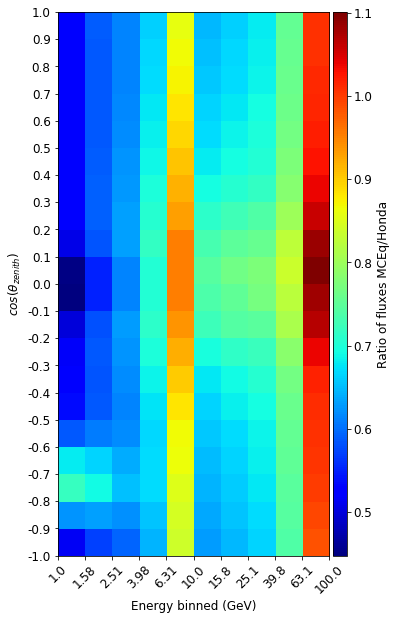

In [90]:
MCEq_flux = np.genfromtxt('MCEq_2dflux', delimiter=',')

flux_plot(MCEq_flux/binned_cropped_matrix, cbar_label= 'Ratio of fluxes MCEq/Honda'); #, savefig = 'ratio_flux');